<a href="https://colab.research.google.com/github/kridtapon/WFO-HMA-Overdrive/blob/main/WFO_HMA_Overdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
<ipython-input-3-c221c276f794>:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-c221c276f794>:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-c221c276f794>:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return


Walk-Forward Optimization Results:
   Year              Best_Params  Test_Return
0  2020  (17, 25, 30, 2.5, 5, 3)     1.167380
1  2021  (17, 21, 26, 2.5, 5, 3)    -0.072776
2  2022  (17, 21, 26, 2.5, 5, 3)     0.087733
3  2023   (5, 21, 22, 2.5, 5, 1)     0.558699
4  2024   (5, 21, 26, 2.5, 5, 1)     0.722594
5  2025   (5, 21, 18, 2.5, 5, 1)     0.000000


<ipython-input-3-c221c276f794>:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-c221c276f794>:147: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-c221c276f794>:148: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-c221c

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            761485.88536
Total Return [%]                       661.485885
Benchmark Return [%]                   607.753959
Max Gross Exposure [%]                      100.0
Total Fees Paid                       1548.877424
Max Drawdown [%]                          33.6111
Max Drawdown Duration                       332.0
Total Trades                                    5
Total Closed Trades                             4
Total Open Trades                               1
Open Trade PnL                       574680.41299
Win Rate [%]                                 50.0
Best Trade [%]                         114.744764
Worst Trade [%]                         -18.55881
Avg Winning Trade [%]                   61.885893
Avg Losing Trade [%]                   -10.276833


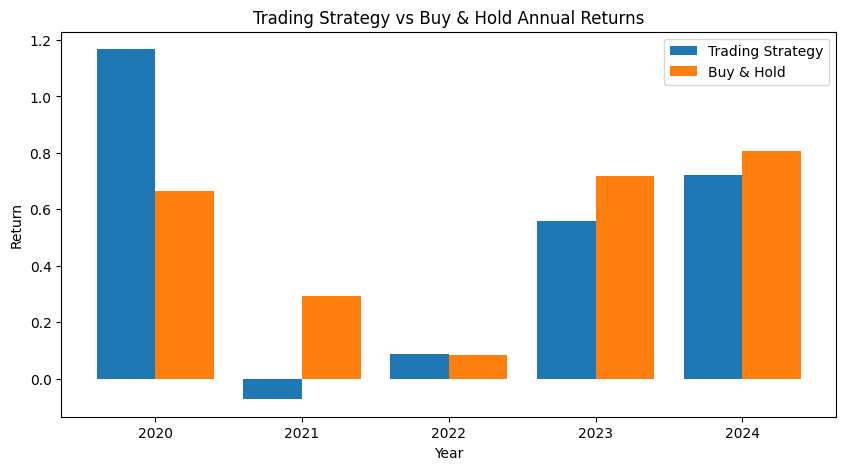

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Weighted Moving Average (WMA)
def wma(series, period):
    weights = np.arange(1, period + 1)
    return series.rolling(period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Function to calculate Hull Moving Average (HMA)
def hma(series, period):
    half_length = int(period / 2)
    sqrt_length = int(np.sqrt(period))

    wma_half = wma(series, half_length)
    wma_full = wma(series, period)
    hma_series = wma(2 * wma_half - wma_full, sqrt_length)

    return hma_series

# Function to calculate ATR
def calculate_atr(df, period=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

# Walk-forward optimization with HMA Crossover and ATR
def walk_forward_optimization_hma(df, start_year, end_year):
    results = []

    # Define dynamic ranges for HMA and ATR parameters
    hma_short_period_range = range(1, 20, 4)  # Range for short-term HMA periods
    hma_long_period_range = range(21, 40, 4)  # Range for long-term HMA periods
    atr_period_range = range(10, 31, 4)  # Range for ATR periods
    atr_multiplier_range = [1.5, 2, 2.5]  # ATR multiplier range
    entry_shift_range = range(1, 10, 2)  # Range for entry shift
    exit_shift_range = range(1, 10, 2)  # Range for exit shift

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of parameters
        for params in itertools.product(hma_short_period_range, hma_long_period_range, atr_period_range,
                                        atr_multiplier_range, entry_shift_range, exit_shift_range):
            hma_short_period, hma_long_period, atr_period, atr_multiplier, entry_shift, exit_shift = params

            # Calculate HMA and ATR indicators on the training data
            train_data['HMA_Short'] = hma(train_data['Close'], hma_short_period)
            train_data['HMA_Long'] = hma(train_data['Close'], hma_long_period)
            train_data['ATR'] = calculate_atr(train_data, atr_period)

            # Generate entry and exit signals based on HMA crossover & ATR
            entries = (train_data['HMA_Short'] > train_data['HMA_Long']) & \
                      (train_data['Close'] > train_data['Close'].shift(entry_shift) + atr_multiplier * train_data['ATR'])
            exits = (train_data['HMA_Short'] < train_data['HMA_Long']) & \
                    (train_data['Close'] < train_data['Close'].shift(exit_shift) - atr_multiplier * train_data['ATR'])

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = params

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply HMA and ATR indicators
        yearly_data['HMA_Short'] = hma(yearly_data['Close'], best_params[0])
        yearly_data['HMA_Long'] = hma(yearly_data['Close'], best_params[1])
        yearly_data['ATR'] = calculate_atr(yearly_data, best_params[2])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['HMA_Short'] > yearly_data['HMA_Long']) & \
                  (yearly_data['Close'] > yearly_data['Close'].shift(best_params[4]) + best_params[3] * yearly_data['ATR'])
        exits = (yearly_data['HMA_Short'] < yearly_data['HMA_Long']) & \
                (yearly_data['Close'] < yearly_data['Close'].shift(best_params[5]) - best_params[3] * yearly_data['ATR'])

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'DECK' # ANET DECK! HWM TPR! BTC-USD SPY
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_hma(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply HMA and ATR indicators
    yearly_data['HMA_Short'] = hma(yearly_data['Close'], params[0])
    yearly_data['HMA_Long'] = hma(yearly_data['Close'], params[1])
    yearly_data['ATR'] = calculate_atr(yearly_data, params[2])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['HMA_Short'] > yearly_data['HMA_Long']) & \
              (yearly_data['Close'] > yearly_data['Close'].shift(params[4]) + params[3] * yearly_data['ATR'])
    exits = (yearly_data['HMA_Short'] < yearly_data['HMA_Long']) & \
            (yearly_data['Close'] < yearly_data['Close'].shift(params[5]) - params[3] * yearly_data['ATR'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [4]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,707753.95887
Total Return [%],607.753959
Benchmark Return [%],607.753959
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],54.687345
